# Objective Functions: A Simple Example with Matrix Factorisation.

### 6th October 2015 Neil D. Lawrence

### Modified by Mauricio A Álvarez, 1st October 2018

In last week's class we saw how we could load in a data set to pandas and use it for some simple data processing. We computed various probabilities on the data and I encouraged you to think about what sort of probabilities you need for prediction. This week we are going to take a slightly different tack. 

Broadly speaking there are two dominating approaches to machine learning problems. We started to consider the first approach last week: constructing models based on defining the relationship between variables using probabilities. This week we will consider the second approach: which involves defining an *objective function* and optimizing it. 

What do we mean by an objective function? An objective function could be an *error function*, a *cost function* or a *benefit* function. In evolutionary computing they are called *fitness* functions. But the idea is always the same. We write down a mathematical equation which is then optimized to do the learning. The equation should be a function of the *data* and our model *parameters*. We have a choice when optimizing, either minimize or maximize. To avoid confusion, in the optimization field, we always choose to minimize the function. If we have a function that we would like to maximize, we simply choose to minimize the negative of that function. 

So for this lab session, we are going to ignore probabilities, but don't worry, they will return! 

This week we are going to try and build a simple movie recommender system using an objective function. To do this, the first thing I'd like you to do is to install some software we've written for sharing information across google documents.

## Open Data Science Software

In Sheffield we have written a suite of software tools for 'Open Data Science'. Open data science is an approach to sharing code, models and data that should make it easier for companies, health professionals and scientists to gain access to data science techniques. For some background on open data science you can read [this blog post](http://inverseprobability.com/2014/07/01/open-data-science/). The first thing we will do this week is to download that suite of software. 

The software can be installed using

```python
pip install pods
```

from the command prompt where you can access your python installation.


## Download the MovieLens 100k Data

We are going to download the [MovieLens 100k](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html) Data. This is a public dataset that contains 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. When you use a data set that someone has prepared you should always reference the data source to acknowledge the work that's been placed in. This particular dataset was collected by the [Grouplens Research group](https://grouplens.org/),  at the University of Minnesota. For example, if you were to use this dataset for writing a paper, the authors ask you that you acknowledge their work by citing the following paper:

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5 (4):1-19 [https://doi.org/10.1145/2827872](https://doi.org/10.1145/2827872)

In [1]:
import pods
import zipfile
import sys
import pandas as pd
import numpy as np

pods.util.download_url("http://files.grouplens.org/datasets/movielens/ml-latest-small.zip")
zip_console = zipfile.ZipFile('ml-latest-small.zip', 'r')
for name in zip_console.namelist():
           zip_console.extract(name, './')

[==============================]   0.933/0.933MB                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

### Assignment Question 1

Data ethics. If you find data available on the internet, can you simply use it without consequence? If you are given data by a fellow researcher can you publish that data on line? 

*5 marks*

#### Question 1 Answer

No, we cannot simply use data available on the internet without consequence. We should read about data privacy, also called information privacy, which is the aspect of information technology (IT) that deals with the ability an organization or individual has to determine what data can be used for own purposes or shared with third parties. It is absolutely necessary for us to abide by the guidelines set by them and use the information available on the internet with responsibility.

No, we cannot publish any data given by a fellow researcher, online, without his prior permission. It is also important that he consents to the same only upon knowing proper data ethics. We all must also know the legal implications of the published material and be aware of the proper legislation and codes of practice.

Reference: [1] Data Protection, “Open Government Licence for Public Sector Information”. [Online]. Available: https://www.gov.uk/data-protection. Accessed on October, 9, 2018.

## Recommender Systems

A recommender system aims to make suggestions for items (films, books, other commercial products) given what it knows about users' tastes. The recommendation engine needs to represent the *taste* of all the users and the *characteristics* of each object. 

A common way for organizing objects is to place related objects spatially close together. For example in a library we try and put books that are on related topics near to each other on the shelves. One system for doing this is known as [Dewey Decimal Classification](http://en.wikipedia.org/wiki/Dewey_Decimal_Classification). In the Dewey Decimal Classification system (which dates from 1876) each subject is given a number (in fact it's a decimal number). For example, the field of Natural Sciences and Mathematics is given numbers which start with 500. Subjects based on Computer Science are given numbers which start 004 and works on the 'mathematical principles' of Computer science are given the series 004.0151 (which we might store as 4.0151 on a Computer). Whilst it's a classification system, the books in the library are typically laid out in the same order as the numbers, so we might expect that neighbouring numbers represent books that are related in subject. That seems to be exactly what we want when also representing films. Could we somehow represent each film's subject according to a number? In a similar way we could then imagine representing users with a list of numbers that represent things that each user is interested in.

Actually a one dimensional representation of a subject can be very awkward. To see this, let's have a look at the Dewey Decimal Classification numbers for the 900s, which is listed as 'History and Geography'. We will focus on subjects in the 940s which can be found in this list from [Wikipedia](https://en.wikipedia.org/wiki/List_of_Dewey_Decimal_classes#Class_900_%E2%80%93_History_&_geography). Whilst the ordering for places is somewhat sensible, it is also rather arbitrary. In the 940s we have Europe listed from 940-949, Asia listed from 950-959 and Africa listed from 960-969. Whilst it's true that Asia borders Europe, Africa is also very close, and the history of the Roman Empire spreads into [Carthage](http://en.wikipedia.org/wiki/Carthage) and later on Egypt. This image from Wikipedia shows a map of the Cathaginian Empire which fell after fighting with Rome. 


<a title="By Javierfv1212 [Public domain], from Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Carthaginianempire.PNG"><img width="512" alt="Carthaginianempire" src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9b/Carthaginianempire.PNG/512px-Carthaginianempire.PNG"></a>

We now need to make a decision about whether Roman Histories are European or African, ideally we'd like them to be somewhere between the two, but we can't place them there in the Dewey Decimal system because between Europe and Africa is Asia, which has less to do with the Roman Empire than either Europe or Africa. Of course the fact that we've used a map provides a clue as to what to do next. Libraries are actually laid out on floors, so what if we were to use the spatial lay out to organise the sujbects of the books in two dimensions. Books on Geography could be laid out according to where in the world they are referring to. 

Such complexities are very hard to encapsulate in one number, but inspired by the map examples we can start considering how we might lay out films in two dimensions. Similarly, we can consider laying out a map of people's interests. If the two maps correspond to one another, the map of people could reflect where they might want to live in 'subject space'. We can think of representing people's tastes as where they might best like to sit in the library to access easily the books they are most interested in.


## Inner Products for Representing Similarity

Ideas like the above are good for gaining intuitions about what we might want, but the one of the skills of data science is representing those ideas mathematically. Mathematical abstraction of a problem is one of the key ways in which we've been able to progress as a society. Understanding planetary motions, as well as those of the smallest molecule (to quote Laplace's [Philosophical Essay on Probabilities](http://books.google.co.uk/books?id=1YQPAAAAQAAJ&printsec=frontcover&source=gbs_ge_summary_r&cad=0#v=onepage&q&f=false)) needed to be done mathematically. The right mathematical model in machine learning can be slightly more elusive, because constructing it is a two stage process. 

1. We have to determine the right intuition for the system we want to represent. Notions such as 'subject' and 'interest' are not mathematically well defined, and even when we create a new interpretation of what they might mean, each interpretation may have its own weaknesses. 

2. Once we have our interpretation we can attempt to mathematically formalize it. In our library interpretation, that's what we need to do next. 

### The Library on an Infinite Plane

Let's imagine a library which stores all the items  we are interested in, not just books, but films and shopping items too. Such a library is likely to be very large, so we'll create it on an infinite two dimensional plane. This means we can use all the real numbers to represent the location of each item on the plane. For a two dimensional plane, we need to store the locations in a vector of numbers: we can decide that the $j$th item's location in the library is given by 
$$
\mathbf{v}_j = \begin{bmatrix} v_{j,1} \\ v_{j,2}\end{bmatrix},
$$
where $v_{j,1}$ represents the $j$th item's location in the East-West direction (or the $x$-axis) and $v_{j,2}$ represents the $j$th item's location in the North-South direction (or the $y$-axis). Now we need to specify the location where each user sits so that all the items that interest them are nearby: we can also represent the $i$th user's location with a vector 
$$
\mathbf{u}_i = \begin{bmatrix} u_{i,1} \\ u_{i,2}\end{bmatrix}.
$$
Finally, we need some way of recording a given user's affinity for a given item. This affinity might be the rating that the user gives the film. We can use $y_{i,j}$ to represent user $i$'s affinity for item $j$. 

For our film example we might imagine wanting to order films in a few ways. We could imagine organising films in the North-South direction as to how romantic they are. We could place the more romantic films further North and the less romantic films further South. For the East-West direction we could imagine ordering them according to how historic they are: we can imagine placing science fiction films to the East and historical drama to the West. In this case, fans of historical romances would be based in the North-West location, whilst fans of Science Fiction Action films might be located in the South-East (if we assume that 'Action' is the opposite of 'Romance', which is not necessarily the case). How do we lay out all these films? Have we got the right axes? In machine learning the answer is to 'let the data speak'. Use the data to try and obtain such a lay out. To do this we first need to obtain the data.

## Obtaining the Data

As mentioned before, the MovieLens dataset that we'll use has 100,000 ratings to 9,000 movies by 600 users. For now, we will only work with a subset of the dataset. In particular, we will randomly chose a particular number of users and extract the movies and ratings that the users gave to those movies. Read the code below and understand what it is doing.

**Before you run the code**, notice that `YourStudentID` in the first line is a variable that will specify the seed for the random number generator that will select a particular set of `nUsersInExample` users. Change the number that has been assigned by default to `YourStudentID` to the last three digits of your UCard number. All of you will have a different subset of users.

In [2]:
YourStudentID = 328  # Include here the last three digits of your UCard number
nUsersInExample = 10 # The maximum number of Users we're going to analyse at one time

ratings = pd.read_csv("./ml-latest-small/ratings.csv") 
"""
ratings is a DataFrame with four columns: userId, movieId, rating and tags. We
first want to identify how many unique users there are. We can use the unique 
method in pandas
"""
indexes_unique_users = ratings['userId'].unique()
n_users = indexes_unique_users.shape[0]
""" 
We randomly select 'nUsers' users with their ratings. We first fix the seed
of the random generator to make sure that we always get the same 'nUsers'
"""
np.random.seed(YourStudentID)
indexes_users = np.random.permutation(n_users)
my_batch_users = indexes_users[0:nUsersInExample]
"""
We will use now the list of 'my_batch_users' to create a matrix Y. 
"""
# We need to make a list of the movies that these users have watched
list_movies_each_user = [[] for _ in range(nUsersInExample)]
list_ratings_each_user = [[] for _ in range(nUsersInExample)]
# Movies
list_movies = ratings['movieId'][ratings['userId'] == my_batch_users[0]].values
list_movies_each_user[0] = list_movies                    
# Ratings                      
list_ratings = ratings['rating'][ratings['userId'] == my_batch_users[0]].values
list_ratings_each_user[0] = list_ratings
# Users
n_each_user = list_movies.shape[0]
list_users = my_batch_users[0]*np.ones((1, n_each_user))

for i in range(1, nUsersInExample):
    # Movies
    local_list_per_user_movies = ratings['movieId'][ratings['userId'] == my_batch_users[i]].values
    list_movies_each_user[i] = local_list_per_user_movies
    list_movies = np.append(list_movies,local_list_per_user_movies)
    # Ratings                                 
    local_list_per_user_ratings = ratings['rating'][ratings['userId'] == my_batch_users[i]].values
    list_ratings_each_user[i] = local_list_per_user_ratings
    list_ratings = np.append(list_ratings, local_list_per_user_ratings)  
    # Users                                   
    n_each_user = local_list_per_user_movies.shape[0]                                                                               
    local_rep_user =  my_batch_users[i]*np.ones((1, n_each_user))    
    list_users = np.append(list_users, local_rep_user)

# Let us first see how many unique movies have been rated
indexes_unique_movies = np.unique(list_movies)
n_movies = indexes_unique_movies.shape[0]
# As it is expected no all users have rated all movies. We will build a matrix Y 
# with NaN inputs and fill according to the data for each user 
temp = np.empty((n_movies,nUsersInExample,))
temp[:] = np.nan
Y_with_NaNs = pd.DataFrame(temp)
for i in range(nUsersInExample):
 local_movies = list_movies_each_user[i]
 ixs = np.in1d(indexes_unique_movies, local_movies)
 Y_with_NaNs.loc[ixs, i] = list_ratings_each_user[i]

Y_with_NaNs.index = indexes_unique_movies.tolist()
Y_with_NaNs.columns = my_batch_users.tolist()

Y_with_NaNs

,575,472,209,128,281,146,319,204,106,364
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
32,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,3.0
47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN
50,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
110,NaN,NaN,NaN,5.0,NaN,NaN,4.5,NaN,NaN,NaN
135,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
252,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN


### Assignment Question 2

Have a look at the matrix `Y_with_NaNs`. The movies data is now in a data frame which contains one column for each user rating the movie. There are some entries that contain 'NaN'. What does the 'NaN' mean in this context?

*5 marks*

#### Answer Question 2

Setting the seed to the last three digits of my UCard number = 328, 10 random users have been generated in `Y_with_NaNs` matrix.
Here it can be seen that for 9 out of the 10 randomly selected users, the ratings are coming as NaN. Here, NaN means 'Not a Number', which implies that those 9 users have not yet rated the movie since is not possible that every user rates every movie. Hence, in order to feed the user-movie pair in the data frame, we provide NaN input.


Now we will convert our data structure into a form that is appropriate for processing. We will convert the `Y_with_NaNs` dataframe into a new dataframe which contains the user, the movie, and the rating using the following code

In [3]:
p_list_ratings = np.concatenate(list_ratings_each_user).ravel()
p_list_ratings_original = p_list_ratings.tolist()
mean_ratings_train = np.mean(p_list_ratings)
p_list_ratings =  p_list_ratings - mean_ratings_train # remove the mean
p_list_movies = np.concatenate(list_movies_each_user).ravel().tolist()
p_list_users = list_users.tolist()
Y = pd.DataFrame({'users': p_list_users, 'movies': p_list_movies, 'ratingsorig': p_list_ratings_original,'ratings':p_list_ratings.tolist()})
Y

,movies,ratings,ratingsorig,users
0,296,1.055866,5.0,575.0
1,430,1.055866,5.0,575.0
2,1259,1.055866,5.0,575.0
3,2436,-0.944134,3.0,575.0
4,2496,-0.944134,3.0,575.0
5,2497,-0.944134,3.0,575.0
6,2500,-2.944134,1.0,575.0
7,2501,-0.944134,3.0,575.0
8,2504,-0.944134,3.0,575.0
9,2505,-0.944134,3.0,575.0


### Assignment Question 3

The dataframes `Y_with_NaNs` and `Y` contain the same information but organised in a different way. Explain what is the difference. We have also included two columns for ratings in dataframe `Y`, `ratingsorig` and `ratings`. Explain
the difference. 

*10 marks*

#### Question 3 Answer

The dataframe `Y_with_NaNs` is a matrix that has the ratings given to each movie by each user, i.e., they have included all the movies and all the users, and for those movies which a user hasn't rated yet, the value has been updated with NaN. 

Now, the dataframe `Y` contains the ratings based on user-movie interaction as well. But here, it has only those movies which have been rated by a user, and those movies which that particular user hasn't rated, have not been taken into consideration. Another difference is that in the `Y` dataframe, two additional columns called `ratingsorig` and `ratings` are present, which is not the case for `Y_with_NaNs` dataframe.

The column `ratingsorig` signifies the original rating that a movie has got by a user. However, the column `ratings` contains those values which are received after subtracting the mean of the ratings given by each user from the original ratings given by that user. It is a technique of linear transformation of the data which shifts the data so that it is centered at the origin. This process is called zero-centering. It helps to normalise and standardise the data.

Reference: [2] The MathWorks, “The MathWorks, Inc. (“MathWorks”)” [Online]. Available: https://uk.mathworks.com. Accessed on October, 9, 2018.

## Measuring Similarity

We now need a measure for determining the similarity between the item and the user: how close the user is sitting to the item in the rooom if you like. We are going to use the inner product between the vector representing the item and the vector representing the user. 

An inner product (or [dot product](http://en.wikipedia.org/wiki/Dot_product)) between two vectors $\mathbf{a}$ and $\mathbf{b}$ is written as $\mathbf{a}\cdot\mathbf{b}$. Or in vector notation we sometimes write it as $\mathbf{a}^\top\mathbf{b}$. An inner product is simply the sume of the products of each element of the vector,
$$
\mathbf{a}^\top\mathbf{b} = \sum_{i} a_i b_i
$$
The inner product can be seen as a measure of similarity. The inner product gives us the cosine of the angle between the two vectors multiplied by their length. The smaller the angle between two vectors the larger the inner product. 
$$
\mathbf{a}^\top\mathbf{b} = |\mathbf{a}||\mathbf{b}| \cos(\theta)
$$
where $\theta$ is the angle between two vectors and $|\mathbf{a}|$ and $|\mathbf{b}|$ are the respective lengths of the two vectors.

Since we want each user to be sitting near each item, then we want the inner product to be large for any two items which are rated highly by that user. We can do this by trying to force the inner product $\mathbf{u}_i^\top\mathbf{v}_j$ to be similar to the rating given by the user, $y_{i,j}$. To ensure this we will use a least squares objective function for all user ratings.

## Objective Function

The error function (or objective function, or cost function) we will choose is known as 'sum of squares', we will aim to minimize the sum of squared squared error between the inner product of $\mathbf{u}_i$ and $\mathbf{v}_i$ and the observed score for the user/item pairing, given by $y_{i, j}$. 

The total objective function can be written as
$$
E(\mathbf{U}, \mathbf{V}) = \sum_{i,j} s_{i,j} (y_{i,j} - \mathbf{u}_i^\top \mathbf{v}_j)^2
$$
where $s_{i,j}$ is an *indicator* variable that is 1 if user $i$ has rated item $j$ and is zero otherwise. Here $\mathbf{U}$ is the matrix made up of all the vectors $\mathbf{u}$,
$$
\mathbf{U} = \begin{bmatrix} \mathbf{u}_1 \dots \mathbf{u}_n\end{bmatrix}^\top
$$
where we note that $i$th *row* of $\mathbf{U}$ contains the vector associated with the $i$th user and $n$ is the total number of users. This form of matrix is known as a *design matrix*. Similarly, we define the matrix
$$
\mathbf{V} = \begin{bmatrix} \mathbf{v}_1 \dots \mathbf{v}_m\end{bmatrix}^\top
$$
where again the $j$th row of $\mathbf{V}$ contains the vector associated with the $j$th item and $m$ is the total number of items in the data set.

## Objective Optimization

The idea is to mimimize this objective. A standard, simple, technique for minimizing an objective is *gradient descent* or *steepest descent*. In gradient descent we simply choose to update each parameter in the model by subtracting a multiple of the objective function's gradient with respect to the parameters. So for a parameter $u_{i,j}$ from the matrix $\mathbf{U}$ we would have an update as follows:
$$
u_{k,\ell} \leftarrow u_{k,\ell} - \eta \frac{\text{d} E(\mathbf{U}, \mathbf{V})}{\text{d}u_{k,\ell}} 
$$
where $\eta$ (which is pronounced *eta* in English) is a Greek letter representing the *learning rate*.  

We can compute the gradient of the objective function with respect to $u_{k,\ell}$ as
$$
\frac{\text{d}E(\mathbf{U}, \mathbf{V})}{\text{d}u_{k,\ell}} = -2 \sum_j s_{k,j}v_{j,\ell}(y_{k, j} - \mathbf{u}_k^\top\mathbf{v}_{j}). 
$$
Similarly each parameter $v_{i,j}$ needs to be updated according to its gradient. 


### Assignment Question 4

What is the gradient of the objective function with respect to $v_{k, \ell}$? Write your answer in the box below, and explain which differentiation techniques you used to get there. You will be expected to justify your answer in class by oral questioning. 

*15 marks*

#### Question 4 Answer

The gradient of the objective function with respect to $v_{k, \ell}$ is:

$$
\frac{\text{d}E(\mathbf{U}, \mathbf{V})}{\text{d}v_{k,\ell}} = -2 \sum_i s_{k,i}u_{i,\ell}^\top\mathbf(y_{k, i} - \mathbf{u}_i^\top\mathbf{v}_{k}). 
$$

The differentiation techniques I used were power rule and chain rule for composite functions. That gives us above for the gradient with respect to the movie V(iteration k, dimension l).

In [20]:
# Question 4 Code Answer

## Steepest Descent Algorithm

In the steepest descent algorithm we aim to minimize the objective function by subtacting the gradient of the objective function from the parameters. 

### Initialisation

To start with though, we need initial values for the matrix $\mathbf{U}$ and the matrix $\mathbf{V}$. Let's create them as `pandas` data frames and initialise them randomly with small values.

In [4]:
q = 2 # the dimension of our map of the 'library'
learn_rate = 0.02
U = pd.DataFrame(np.random.normal(size=(nUsersInExample, q))*0.001, index=my_batch_users)
V = pd.DataFrame(np.random.normal(size=(n_movies, q))*0.001, index=indexes_unique_movies)

Now that we have the initial values set, we can start the optimization. First we define a function for the gradient of the objective and the objective function itself.

In [7]:
def objective_gradient(Y, U, V): 
    gU = pd.DataFrame(np.zeros((U.shape)), index=U.index)
    gV = pd.DataFrame(np.zeros((V.shape)), index=V.index)
    obj = 0.
    nrows = Y.shape[0]
    for i in range(nrows):
        row = Y.iloc[i]
        user = row['users']
        film = row['movies']
        rating = row['ratings']
        prediction = np.dot(U.loc[user], V.loc[film]) # vTu
        diff = prediction - rating # vTu - y
        obj += diff*diff
        gU.loc[user] += 2*diff*V.loc[film]
        gV.loc[film] += 2*diff*U.loc[user]
    return obj, gU, gV

Now we can write our simple optimisation route. This allows us to observe the objective function as the optimization proceeds.

In [8]:
iterations = 20
for i in range(iterations):
    obj, gU, gV = objective_gradient(Y, U, V)
    print("Iteration", i, "Objective function: ", obj)
    U -= learn_rate*gU
    V -= learn_rate*gV    

Iteration 0 Objective function:  377.8826908104548
Iteration 1 Objective function:  377.88259041497855
Iteration 2 Objective function:  377.8824748794447
Iteration 3 Objective function:  377.8823079355589
Iteration 4 Objective function:  377.88204065758015
Iteration 5 Objective function:  377.8815936354931
Iteration 6 Objective function:  377.8808295547247
Iteration 7 Objective function:  377.8795053974356
Iteration 8 Objective function:  377.8771860802094
Iteration 9 Objective function:  377.873086515259
Iteration 10 Objective function:  377.8657810149151
Iteration 11 Objective function:  377.8526663455192
Iteration 12 Objective function:  377.8289662241643
Iteration 13 Objective function:  377.78588065555914
Iteration 14 Objective function:  377.70713894981975
Iteration 15 Objective function:  377.5625746426796
Iteration 16 Objective function:  377.2961630066312
Iteration 17 Objective function:  376.8038499111947
Iteration 18 Objective function:  375.89291023942354
Iteration 19 Objec

### Assignment Question 5

What happens as you increase the number of iterations? What happens if you increase the learning rate?

*10 marks*

#### Question 5 Answer

The following conditions are observed:

Case 1. Keeping the number of iterations constant, if we increase the learning rate from 0.02 to 0.03, the value of Objective Function decreases from 374.20920541880685 to 210.04316040236964


Case 2. Keeping the learning rate constant, if we increase the number of iterations from 20 to 30, the value of Objective Function decreases, but not as quickly as Case 1. 


(On the 19th iteration, in Case 1, the value Objective Function was 210.04316040236964, while the value of Objective Function for Case 2, was 373.4970960781127)

In [9]:
# Question 5 Code Answer

q = 2 # the dimension of our map of the 'library'
learn_rate = 0.02
U = pd.DataFrame(np.random.normal(size=(nUsersInExample, q))*0.001, index=my_batch_users)
V = pd.DataFrame(np.random.normal(size=(n_movies, q))*0.001, index=indexes_unique_movies)

def objective_gradient(Y, U, V):
    gU = pd.DataFrame(np.zeros((U.shape)), index=U.index)
    gV = pd.DataFrame(np.zeros((V.shape)), index=V.index)
    obj = 0.
    nrows = Y.shape[0]
    for i in range(nrows):
        row = Y.iloc[i]
        user = row['users']
        film = row['movies']
        rating = row['ratings']
        prediction = np.dot(U.loc[user], V.loc[film]) # vTu
        diff = prediction - rating # vTu - y
        obj += diff*diff
        gU.loc[user] += 2*diff*V.loc[film]
        gV.loc[film] += 2*diff*U.loc[user]
    return obj, gU, gV

iterations = 30
for i in range(iterations):
    obj, gU, gV = objective_gradient(Y, U, V)
    print("Iteration", i, "Objective function: ", obj)
    U -= learn_rate*gU
    V -= learn_rate*gV  

Iteration 0 Objective function:  377.8826948766772
Iteration 1 Objective function:  377.88253438891905
Iteration 2 Objective function:  377.8823471593837
Iteration 3 Objective function:  377.8820863264344
Iteration 4 Objective function:  377.88168560060006
Iteration 5 Objective function:  377.8810379449448
Iteration 6 Objective function:  377.8799609976731
Iteration 7 Objective function:  377.8781365404127
Iteration 8 Objective function:  377.8750018953709
Iteration 9 Objective function:  377.86955313225945
Iteration 10 Objective function:  377.8599864783888
Iteration 11 Objective function:  377.843042318426
Iteration 12 Objective function:  377.81280142157556
Iteration 13 Objective function:  377.75847083967534
Iteration 14 Objective function:  377.66030554756924
Iteration 15 Objective function:  377.4820946248054
Iteration 16 Objective function:  377.1573439756186
Iteration 17 Objective function:  376.5640080405295
Iteration 18 Objective function:  375.47884933704535
Iteration 19 Obj

## Making Predictions

Predictions can be made from the model of the appropriate rating for a given user, $i$, for a given film, $j$, by simply taking the inner product between their vectors $\mathbf{u}_i$ and $\mathbf{v}_j$. 

### Assignment Question 6

Create a function that provides the prediction of the ratings for the users in the dataset. Is the quality of the predictions affected by the number of iterations or the learning rate? The function should receive `Y`, `U` and `V` and return the predictions and the absolute error between the predictions and the actual rating given by the users. The predictions and the absolute error should be added as additional columns to the dataframe `Y`.

*15 marks*

In [10]:
# Question 6 Code Answer

# defining our function
def new_prediction_function(Y,U,V):
    prediction_new = np.zeros((Y.shape[0]))
    absolute_error = np.zeros((Y.shape[0]))
    error_sum = 0
    for i in range(Y.shape[0]):
        row = Y.iloc[i]
        user = row['users']
        film = row['movies']
        rating = row['ratings']
        prediction = np.dot(U.loc[user], V.loc[film]) # vTu
        diff = prediction - rating # vTu - y
        prediction_new[i] = prediction
        absolute_error[i] = abs(diff) # absolute error between the predictions
 
    Y['Predictions'] = prediction_new # adding the additional column Predictions
    Y['Absolute Error'] = absolute_error # adding the additional column Predictions

    return(prediction_new,absolute_error)
prediction_new,absolute_error = new_prediction_function(Y,U,V)
Y


,users,movies,ratingsorig,ratings,Predictions,Absolute Error
0,575.0,296,5.0,1.055866,0.803414,0.252452
1,575.0,430,5.0,1.055866,1.037083,0.018783
2,575.0,1259,5.0,1.055866,1.037349,0.018517
3,575.0,2436,3.0,-0.944134,-0.928327,0.015807
4,575.0,2496,3.0,-0.944134,-0.926565,0.017569
5,575.0,2497,3.0,-0.944134,-0.928317,0.015817
6,575.0,2500,1.0,-2.944134,-2.891478,0.052656
7,575.0,2501,3.0,-0.944134,-0.927949,0.016185
8,575.0,2504,3.0,-0.944134,-0.926260,0.017874
9,575.0,2505,3.0,-0.944134,-0.926486,0.017648


#### Question 6 Answer

Effect on Quality of Predictions:

Yes, Learning Rate and Iterations have an effect on the prediction quality as learning rate is a decreasing function of time and determines how each iteration is going to behave. On the other hand, the number of iterations indicates the number of times the algorithm's parameters are updated, so that U and V move closer to the actual values.

## Stochastic Gradient Descent or Robbins Monroe Algorithm

Stochastic gradient descent involves updating separating each gradient update according to each separate observation, rather than summing over them all. It is an approximate optimization method, but it has proven convergence under certain conditions and can be much faster in practice. It is used widely by internet companies for doing machine learning in practice. For example, Facebook's ad ranking algorithm uses stochastic gradient descent. 

### Assignment Question 7

Create a stochastic gradient descent version of the algorithm. Monitor the objective function after every 1000 updates to ensure that it is decreasing. When you have finished, plot the movie map and the user map in two dimensions (you can use the columns of the matrices $\mathbf{U}$ for the user map and the columns of $\mathbf{V}$ for the movie map). Provide three observations about these maps.

*25 marks*

In [5]:
# Question 7 Code Answer

import pandas as pd
q = 2 # the dimension of our map of the 'library'
learn_rate = 0.02
U = pd.DataFrame(np.random.normal(size=(nUsersInExample, q))*0.001, index=my_batch_users)
V = pd.DataFrame(np.random.normal(size=(n_movies, q))*0.001, index=indexes_unique_movies)
Y = Y.sample(frac=1).reset_index(drop=True) # shuffling our dataset

iter = 50
nrows = Y.shape[0]

update_count = 0 # setting a counter to monitor the objective function after every 1000 updates
for i in range(iter):
    obj = 0
    for j in range(nrows):
        gU = pd.DataFrame(np.zeros((U.shape)), index=U.index)
        gV = pd.DataFrame(np.zeros((V.shape)), index=V.index)
        row = Y.iloc[j]
        user = row['users']
        film = row['movies']
        rating = row['ratings']
        prediction = np.dot(U.loc[user], V.loc[film]) # vTu
        diff = prediction - rating # vTu - y
        obj += diff*diff
        gU.loc[user] += 2*diff*V.loc[film]
        gV.loc[film] += 2*diff*U.loc[user]
        U -= learn_rate*gU
        V -= learn_rate*gV 
        update_count += 1
        # setting the condition
        if(update_count==1000):
            print("Iteration", i, "Objective function: ", obj)
            update_count = 0    
             

Iteration 2 Objective function:  292.62763698301603
Iteration 5 Objective function:  202.03694356012463
Iteration 8 Objective function:  114.86212083356024
Iteration 11 Objective function:  44.10353603016158
Iteration 13 Objective function:  359.32886780588706
Iteration 16 Objective function:  278.34287380559067
Iteration 19 Objective function:  186.16275101062254
Iteration 22 Objective function:  90.26490292667273
Iteration 25 Objective function:  23.54436128466408
Iteration 27 Objective function:  182.4883627777992
Iteration 30 Objective function:  109.74768821883738
Iteration 33 Objective function:  52.06836258910315
Iteration 36 Objective function:  17.137709034975835
Iteration 39 Objective function:  4.2162988663968175
Iteration 41 Objective function:  29.064813861265677
Iteration 44 Objective function:  14.861675431017183
Iteration 47 Objective function:  4.749988291470813


Text(0.5,1,'Usermap')

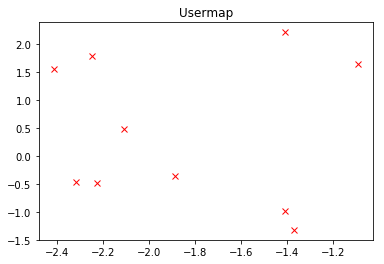

In [6]:
# plotting the User Map
%matplotlib inline
import pylab as plt
plt.plot(U.iloc[:,0], U.iloc[:,1], 'rx')
plt.title('Usermap')

Text(0.5,1,'Moviemap')

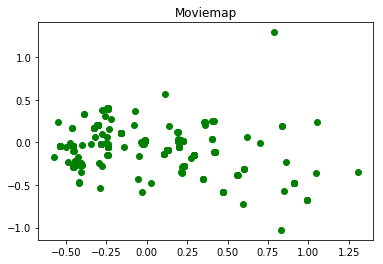

In [7]:
# plotting the Movie Map
%matplotlib inline
import pylab as plt
plt.plot(V.iloc[:,0], V.iloc[:,1], 'go')
plt.title('Moviemap')

#### Question 7 Answer

Observations:
1. From the first plot, we can observe that the points that are near each other show that those users have similar taste in movies and that is why they have given similar ratings.
2. From the second plot, we can observe that the area which has the highest density signifies those movies which have been highly rated.
3. From both the plots, we can observe that all the users have not rated every movie.

## Is Our Map Enough? Are Our Data Enough?

Is two dimensions really enough to capture the complexity of humans and their artforms? Perhaps we need even more dimensions to capture that complexity. Extending our books analogy further, consider how we should place books that have a historical timeframe as well as some geographical location. Do we really want books from the 2nd World War to sit alongside books from the Roman Empire? Books on the American invasion of Sicily in 1943 are perhaps less related to books about Carthage than those that study the Jewish Revolt from 66-70 (in the Roman Province of Judaea). So books that relate to subjects which are closer in time should be stored together. However, a student of rebellion against empire may also be interested in the relationship between the Jewish Revolt of 66-70 and the Indian Rebellion of 1857, nearly 1800 years later. Whilst the technologies are different, the psychology of the people is shared: a rebellious nation angainst their imperial masters, triggered by misrule with a religious and cultural background. To capture such complexities we would need further dimensions in our latent representation. But are further dimensions justified by the amount of data we have? Can we really understand the facets of a film that only has at most three or four ratings?

## Going Further

If you want to take this model further then you'll need more data. You can use again the MovieLens 100k data but increasing the number of users (for example, for the Steepest Descent Algorithm you can do this by modifying the variable `nUsersInExample` that was set as 10 before).

### Assignment Question 8

Use stochastic gradient descent to make a movie map for the MovieLens 100k data. Plot the map of the movies when you are finished.

*15 marks*

In [5]:
# Code for question 8 here.
import pandas as pd

YourStudentID = 328  # Include here the last three digits of your UCard number

ratings = pd.read_csv("./ml-latest-small/ratings.csv") 
"""
ratings is a DataFrame with four columns: userId, movieId, rating and tags. We
first want to identify how many unique users there are. We can use the unique 
method in pandas
"""
indexes_unique_users = ratings['userId'].unique()
n_users = indexes_unique_users.shape[0]
nUsersInExample = n_users # For all users
""" 
We randomly select 'nUsers' users with their ratings. We first fix the seed
of the random generator to make sure that we always get the same 'nUsers'
"""
np.random.seed(YourStudentID)
indexes_users = np.random.permutation(n_users)
my_batch_users = indexes_users[0:nUsersInExample]
"""
We will use now the list of 'my_batch_users' to create a matrix Y. 
"""
# We need to make a list of the movies that these users have watched
list_movies_each_user = [[] for _ in range(nUsersInExample)]
list_ratings_each_user = [[] for _ in range(nUsersInExample)]
# Movies
list_movies = ratings['movieId'][ratings['userId'] == my_batch_users[0]].values
list_movies_each_user[0] = list_movies                    
# Ratings                      
list_ratings = ratings['rating'][ratings['userId'] == my_batch_users[0]].values
list_ratings_each_user[0] = list_ratings
# Users
n_each_user = list_movies.shape[0]
list_users = my_batch_users[0]*np.ones((1, n_each_user))

for i in range(1, nUsersInExample):
    # Movies
    local_list_per_user_movies = ratings['movieId'][ratings['userId'] == my_batch_users[i]].values
    list_movies_each_user[i] = local_list_per_user_movies
    list_movies = np.append(list_movies,local_list_per_user_movies)
    # Ratings                                 
    local_list_per_user_ratings = ratings['rating'][ratings['userId'] == my_batch_users[i]].values
    list_ratings_each_user[i] = local_list_per_user_ratings
    list_ratings = np.append(list_ratings, local_list_per_user_ratings)  
    # Users                                   
    n_each_user = local_list_per_user_movies.shape[0]                                                                               
    local_rep_user =  my_batch_users[i]*np.ones((1, n_each_user))    
    list_users = np.append(list_users, local_rep_user)

# Let us first see how many unique movies have been rated
indexes_unique_movies = np.unique(list_movies)
n_movies = indexes_unique_movies.shape[0]
# As it is expected no all users have rated all movies. We will build a matrix Y 
# with NaN inputs and fill according to the data for each user 
temp = np.empty((n_movies,nUsersInExample,))
temp[:] = np.nan
Y_with_NaNs = pd.DataFrame(temp)
for i in range(nUsersInExample):
 local_movies = list_movies_each_user[i]
 ixs = np.in1d(indexes_unique_movies, local_movies)
 Y_with_NaNs.loc[ixs, i] = list_ratings_each_user[i]

Y_with_NaNs.index = indexes_unique_movies.tolist()
Y_with_NaNs.columns = my_batch_users.tolist()
Y_with_NaNs

,575,472,209,128,281,146,319,204,106,364,...,484,563,334,137,300,222,1,191,437,84
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,4.5,NaN,3.5,4.0,NaN,NaN,4.0,4.0,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.5,2.5,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,5.0,4.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,3.0


In [6]:
p_list_ratings = np.concatenate(list_ratings_each_user).ravel()
p_list_ratings_original = p_list_ratings.tolist()
mean_ratings_train = np.mean(p_list_ratings)
p_list_ratings =  p_list_ratings - mean_ratings_train # remove the mean
p_list_movies = np.concatenate(list_movies_each_user).ravel().tolist()
p_list_users = list_users.tolist()
Y = pd.DataFrame({'users': p_list_users, 'movies': p_list_movies, 'ratingsorig': p_list_ratings_original,'ratings':p_list_ratings.tolist()})
Y

,movies,ratings,ratingsorig,users
0,296,1.500889,5.0,575.0
1,430,1.500889,5.0,575.0
2,1259,1.500889,5.0,575.0
3,2436,-0.499111,3.0,575.0
4,2496,-0.499111,3.0,575.0
5,2497,-0.499111,3.0,575.0
6,2500,-2.499111,1.0,575.0
7,2501,-0.499111,3.0,575.0
8,2504,-0.499111,3.0,575.0
9,2505,-0.499111,3.0,575.0


In [7]:
q = 2 # the dimension of our map of the 'library'
learn_rate = 0.02
U = pd.DataFrame(np.random.normal(size=(nUsersInExample, q))*0.001, index=my_batch_users)
V = pd.DataFrame(np.random.normal(size=(n_movies, q))*0.001, index=indexes_unique_movies)
Y = Y.sample(frac=1).reset_index(drop=True)

iter = 20
nrows = Y.shape[0]
update_count = 0

for i in range(iter):
    obj = 0
    for j in range(nrows):
        gU = pd.DataFrame(np.zeros((U.shape)), index=U.index)
        gV = pd.DataFrame(np.zeros((V.shape)), index=V.index)
        row = Y.iloc[j]
        user = row['users']
        film = row['movies']
        rating = row['ratings']
        prediction = np.dot(U.loc[user], V.loc[film]) # vTu
        diff = prediction - rating # vTu - y
        obj += diff*diff
        gU.loc[user] += 2*diff*V.loc[film]
        gV.loc[film] += 2*diff*U.loc[user]
        U -= learn_rate*gU
        V -= learn_rate*gV 
        update_count += 1
    print("Iteration", i, "Objective function: ", obj)
         
            

Iteration 0 Objective function:  108591.66722872562
Iteration 1 Objective function:  108590.28282145374
Iteration 2 Objective function:  108191.7384093978
Iteration 3 Objective function:  97809.4674348736
Iteration 4 Objective function:  81826.83816379104
Iteration 5 Objective function:  72342.51906682854
Iteration 6 Objective function:  67996.97739801343
Iteration 7 Objective function:  65730.46330925748
Iteration 8 Objective function:  64332.92564447077
Iteration 9 Objective function:  63375.496202665345
Iteration 10 Objective function:  62673.66879202433
Iteration 11 Objective function:  62132.56698155713
Iteration 12 Objective function:  61699.43009766679
Iteration 13 Objective function:  61343.53089723973
Iteration 14 Objective function:  61046.05476427227
Iteration 15 Objective function:  60794.313730053625
Iteration 16 Objective function:  60578.723796978295
Iteration 17 Objective function:  60391.75429342937
Iteration 18 Objective function:  60227.602229114775
Iteration 19 Obje

Text(0.5,1,'Movieplot for Movielens data')

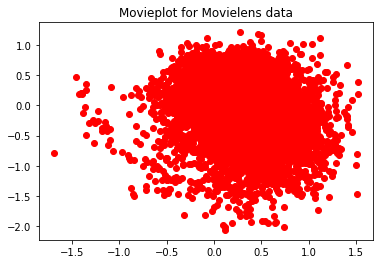

In [8]:
# Plotting the Movie Map
%matplotlib inline
import pylab as plt
plt.plot(V.iloc[:,0], V.iloc[:,1], 'ro')
plt.title('Movieplot for Movielens data')